##Getting Started With Geospatial Data Analysis Forest Cut Temporal Detection. 

This notebook covers the basics of getting started with Geospatial Data Analysis on SageMaker Studio Labs. We start with exploring the sentinel geospatial dataset available at AWS open data registry. We explore deforestation data by analyzing Sentinel-2 geospatial data and calculating spectral indices. Below is the example of Paradise fire in 2018. Similar concept will be used to identified Forest Cut Temporal Detection. 

##Install Packages (Optional)

Creating a environment in Studio Lab is easy, just select the environment.yml file (by cloning this repository or upload it directly), right click the YAML file and select create environment. Once the environment is created, you should open this notbook with the newly created kernel. Optionally you can also uncomment the package installation section of the notebook to install these packages manually.


In [1]:
# %pip install pandas
# %pip install numpy
# %pip install geopandas
# %pip install shapely
# %pip install matplotlib
# %pip install plotly_express
# %pip install sentinelhub
# %pip install rasterio
# %pip install earthpyname: geo-data
# %pip install utils

##Import Packages

After the environment is created and selected or the packages installed manually, we can import them directly.

In [2]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import Point
import matplotlib
import matplotlib.pyplot as plt 
import folium
import plotly_express as px
import os
import warnings
import datetime
warnings.filterwarnings('ignore')

##Working With Geospatial Images

For Geospatial data, we will use Sentinel-2. The Sentinel-2 mission is a land monitoring constellation of two satellites that provide high resolution optical imagery and continuity for the current SPOT and Landsat missions. The Sentinel-2 dataset is available publicly at the AWS open data registry.

We will use the sentinelhub python package, that makes it easy to search and download data specific to our focus area directly from AWS.

In [3]:
from sentinelhub import (
    MimeType,
    CRS,
    BBox,
    SentinelHubRequest,
    SentinelHubDownloadClient,
    DataCollection,
    bbox_to_dimensions,
    DownloadRequest
)



##Sentinel Hub Setup

This section shows how to configure your credentials for sentinelhub. We are using a optional json file to store and retrieve credentials.

We need Setinelhub instance_id and AWS Key and Access ID as requester pays the transfer fees.


In [4]:
from sentinelhub import SHConfig
config = SHConfig()

In [5]:
import json

with open("config.json") as json_data_file:
    cfg = json.load(json_data_file)

In [6]:
# instance_id - Instance ID from from your Sentinel Hub account 
config.instance_id = cfg["sentinelhub"]["instance_id"]

config.aws_access_key_id = cfg["aws"]["access_key_id"]
config.aws_secret_access_key = cfg["aws"]["secret_access_key"]


In [7]:
config.save()

In [8]:
# Verify credentials

from sentinelhub import WebFeatureService, BBox, CRS, DataCollection, SHConfig
if config.instance_id == '':
    print("Warning! To use WFS functionality, please configure the `instance_id`.")

##Data Search 

Before we download, we need to specify our search coordinates that we want to study and the time window. In our case we are focusing on the Paradise, CA region, which we specify as a bounding box and a random time period.

In [9]:
# Specify bounding box and time interval for search

#california paradise after fire
search_bbox = BBox(bbox=[-121.666536,39.708771,-121.542266,39.792182],crs=CRS.WGS84)
#before fire
search_time_interval = ('2018-11-01T00:00:00', '2018-11-01T23:59:59')
#after fire
#search_time_interval = ('2019-01-10T00:00:00', '2019-01-10T23:59:59')

wfs_iterator = WebFeatureService(
    search_bbox,
    search_time_interval,
    data_collection=DataCollection.SENTINEL2_L1C,
    maxcc=1.0,
    config=config
)

for tile_info in wfs_iterator:
    print(tile_info)



{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[-121.8172887117506, 40.64479052115527], [-120.51956282354229, 40.62420116172801], [-120.55525350180832, 39.63588071672625], [-121.83432267419568, 39.65576614324947], [-121.8172887117506, 40.64479052115527]]]]}, 'properties': {'id': 'S2A_OPER_MSI_L1C_TL_MPS__20181104T100109_A017556_T10TFK_N02.06', 'date': '2018-11-01', 'time': '18:55:24', 'path': 's3://sentinel-s2-l1c/tiles/10/T/FK/2018/11/1/0', 'crs': 'EPSG:32610', 'mbr': '600000,4390200 709800,4500000', 'cloudCoverPercentage': 59.2}}
{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'crs': {'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:EPSG::4326'}}, 'coordinates': [[[[-121.83283052717692, 39.74439076989258], [-120.55212699833123, 39.72444308454406], [-120.58625091211863, 38.735945671262385], [-121.84911612911866, 38.755207234120164], [-121.83283052717692, 39.744390

In [10]:
# List available tiles
wfs_iterator.get_tiles()

[('10TFK', '2018-11-1', 0), ('10SFJ', '2018-11-1', 0)]

##Picking Tiles


For best results, we pick a tile with least cloud coverage. for this demo I am picking dates November 2018 (before fire) and November 2019 (after fire)

In [11]:
from sentinelhub import AwsTile

tile_id = 'S2A_OPER_MSI_L1C_TL_MPS__20181104T100109_A017556_T10TFK_N02.06'
tile_name, time, aws_index = AwsTile.tile_id_to_tile(tile_id)
tile_name, time, aws_index




tile_id2 = 'S2A_OPER_MSI_L1C_TL_SGS__20190110T204028_A018557_T10TFK_N02.07'
tile_name2, time2, aws_index2 = AwsTile.tile_id_to_tile(tile_id2)
tile_name2, time2, aws_index2

('10TFK', '2019-1-10', 0)

##Sentinel Data Download 

The Sentinel-2 satellites each carry a single multi-spectral instrument (MSI) with 13 spectral channels in the visible/near infrared (VNIR) and short wave infrared spectral range (SWIR). You can read more about these bands here. For our example will download eight specific bands that will aid our analysis.

In [13]:
warnings.simplefilter("ignore", UserWarning)
from sentinelhub import AwsTileRequest

bands = ['B01','B02','B03','B04','B07','B08','B8A', 'B10','B11','B12']
metafiles = ['tileInfo', 'preview', 'qi/MSK_CLOUDS_B00']
data_folder = './AwsData'


request = AwsTileRequest(
    tile=tile_name,
    time=time,
    aws_index=aws_index,
    bands=bands,
    metafiles=metafiles,
    data_folder=data_folder,
    data_collection=DataCollection.SENTINEL2_L1C
)

request.save_data()

Creating two different request to get two images for comparison.

In [14]:
request2 = AwsTileRequest(
    tile=tile_name2,
    time=time2,
    aws_index=aws_index2,
    bands=bands,
    metafiles=metafiles,
    data_folder=data_folder,
    data_collection=DataCollection.SENTINEL2_L1C
)

request2.save_data()

we have not get the data yet - we create the request object. get_data will actually download the images and different spectrum data.

In [15]:
#Parse the request response 

data_list = request.get_data(redownload=True)

p_b01,p_b02,p_b03,p_b04,p_b07,p_b08,p_b8a,p_b10,p_b11,p_b12,p_tile_info, p_preview, p_cloud_mask = data_list


In [16]:
data_list2 = request2.get_data(redownload=True)

p_b01_2,p_b02_2,p_b03_2,p_b04_2,p_b07_2,p_b08_2,p_b8a_2,p_b10_2,p_b11_2,p_b12_2,p_tile_info_2, p_preview_2, p_cloud_mask_2 = data_list2

Visualize Raw Data Along with the spectral bands, Sentinel tiles also include a preview image, let's check that out first to make sure we have the area of interest captured clearly.

<Figure size 3456x864 with 0 Axes>

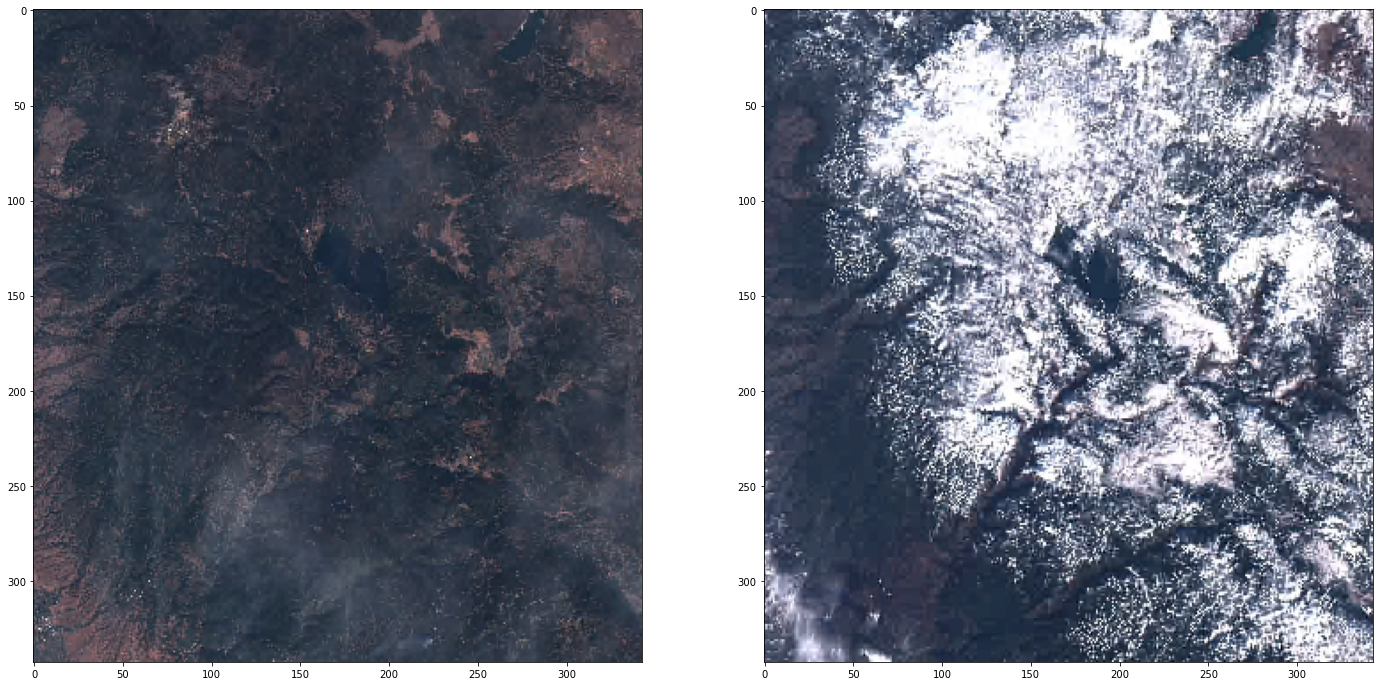

In [17]:
# Preview 

plt.figure(figsize = (48,12))
f, axarr = plt.subplots(1,2,figsize = (24,12));
axarr[0].imshow(p_preview,aspect='auto');
axarr[1].imshow(p_preview_2,aspect='auto');

##Working with Raster Data

Geospatial data is essentially comprised of raster data or vector data. Sentinel-2 uses GeoTIFF, a gridded raster datasets for satellite imagery and terrain models. Rasterio is a Python library that allows to read, inspect, visualize and write geospatial raster data. Here we use rasterio to read thee raster arrays and then use this data to create a true color image.

In [19]:
import rasterio
from rasterio import plot

For getting to the true color images, we will need the blue, green, red and NIR bands.

In [20]:
#changing the time variable to two digit of month and day due to folder creation accordigly 
timesplit = time.split("-")
newtime=''
for splitedval in timesplit:
    if len(newtime) > 0:
        newtime += "-"
    if len(splitedval) == 1:
        splitedval = '%02d' % int(splitedval)
        #print(splitedval)
        newtime += splitedval
    else:
        newtime += splitedval


In [21]:
#changing the time variable to two digit of month and day due to folder creation accordigly 
timesplit = time2.split("-")
newtime2=''
for splitedval in timesplit:
    if len(newtime2) > 0:
        newtime2 += "-"
    if len(splitedval) == 1:
        splitedval = '%02d' % int(splitedval)
        #print(splitedval)
        newtime2 += splitedval
    else:
        newtime2 += splitedval


In [22]:
localpath = './AwsData/'+tile_name+','+newtime+','+str(aws_index)
localpath2 = './AwsData/'+tile_name2+','+newtime2+','+str(aws_index2)

##Calculating Spectral Indices

Spectral indices are combinations of the pixel values from two or more spectral bands in a multispectral image. Spectral indices highlight pixels showing the relative abundance or lack of a land-cover type of interest in an image. Let's looks at a couple

##Normalized Difference Vegetation Index - NVDI

The normalized difference vegetation index is a simple graphical indicator that can be used to analyze whether or not the target being observed contains live green vegetation.

It calculated as NDVI = (NIR – Red) / (NIR + Red)

In [27]:
#image 1

b4 = rasterio.open(localpath+'/B04.jp2')
b8 = rasterio.open(localpath+'/B08.jp2')

# read Red(b4) and NIR(b8) as arrays
red = b4.read()
nir = b8.read()
ndvi = (nir.astype(float)-red.astype(float))/(nir.astype(float)+red.astype(float))

In [28]:
#image 2

b4_2 = rasterio.open(localpath2+'/B04.jp2')
b8_2 = rasterio.open(localpath2+'/B08.jp2')

# read Red(b4) and NIR(b8) as arrays
red_2 = b4_2.read()
nir_2 = b8_2.read()
ndvi_2 = (nir_2.astype(float)-red_2.astype(float))/(nir_2.astype(float)+red_2.astype(float))

The earthpy package allows easy plotting of visualization of bands, we use it here to visualize the Normalized Difference Vegetation index around the selected region.

In [29]:
import earthpy.spatial as es
import earthpy.plot as ep

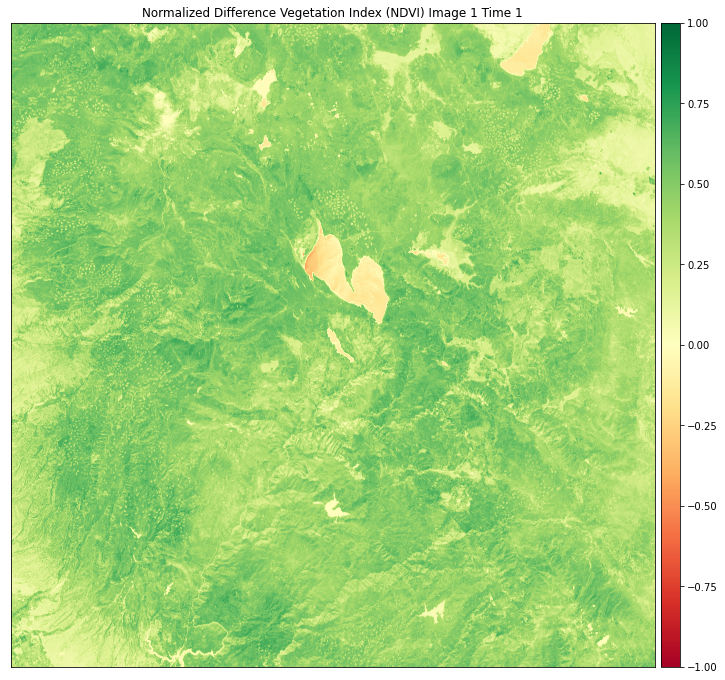

In [30]:
#image 1

title = "Normalized Difference Vegetation Index (NDVI) Image 1 Time 1"
ep.plot_bands(ndvi, cmap="RdYlGn", cols=1, title=title, vmin=-1, vmax=1);


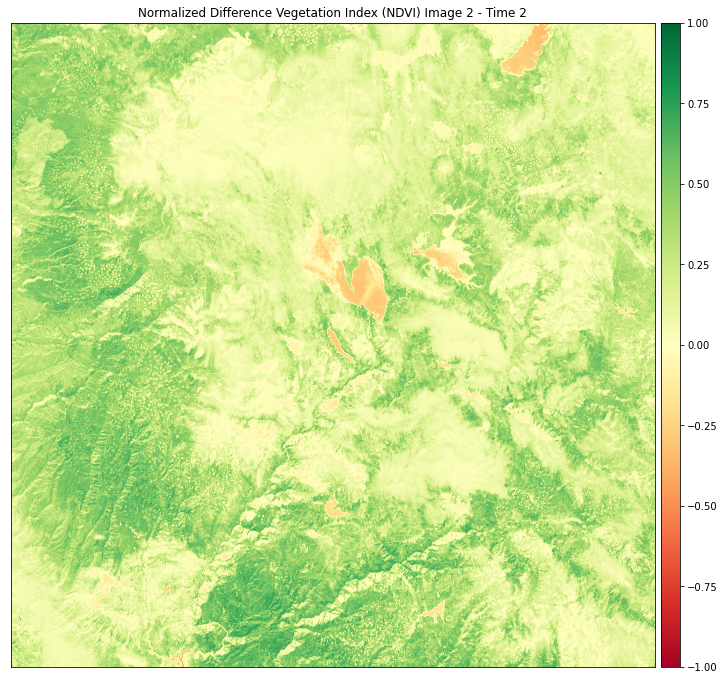

In [31]:

#image 2
title2 = "Normalized Difference Vegetation Index (NDVI) Image 2 - Time 2"
ep.plot_bands(ndvi_2, cmap="RdYlGn", cols=1, title=title2, vmin=-1, vmax=1);

Now we see spectrum and realize vegetation index in the images. Lets classify these spectrum into different bins and utilize earthpy to visualize the same.

In [32]:
# Create classes and apply to NDVI results
ndvi_class_bins = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_landsat_class = np.digitize(ndvi, ndvi_class_bins)

# Apply the nodata mask to the newly classified NDVI data
ndvi_landsat_class = np.ma.masked_where(
    np.ma.getmask(ndvi), ndvi_landsat_class
)
np.unique(ndvi_landsat_class)

masked_array(data=[1, 2, 3, 4, 5],
             mask=False,
       fill_value=999999)

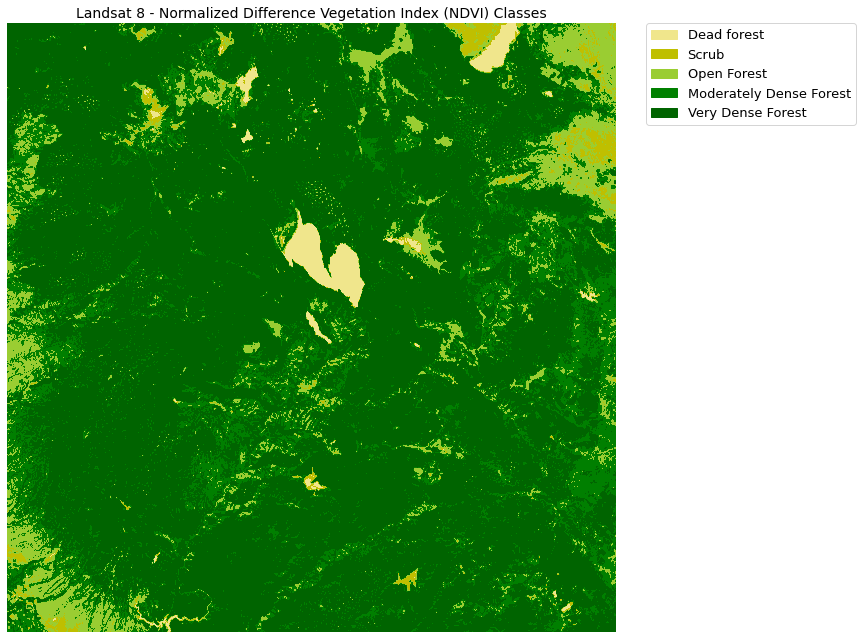

In [33]:
from matplotlib.colors import ListedColormap
# Define color map
nbr_colors = ["khaki", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap = ListedColormap(nbr_colors)

# Define class names
ndvi_cat_names = [
    "Dead forest",
    "Scrub",
    "Open Forest",
    "Moderately Dense Forest",
    "Very Dense Forest",
]

# Get list of classes
classes = np.unique(ndvi_landsat_class)
classes = classes.tolist()
# The mask returns a value of none in the classes. remove that
classes = classes[0:5]

# Plot your data
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(np.squeeze(ndvi_landsat_class), cmap=nbr_cmap)

ep.draw_legend(im_ax=im, classes=classes, titles=ndvi_cat_names)
ax.set_title(
    "Landsat 8 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()


In [34]:
# Create classes and apply to NDVI results
ndvi_class_bins_2 = [-np.inf, 0, 0.1, 0.25, 0.4, np.inf]
ndvi_landsat_class_2 = np.digitize(ndvi_2, ndvi_class_bins_2)

# Apply the nodata mask to the newly classified NDVI data
ndvi_landsat_class_2 = np.ma.masked_where(
    np.ma.getmask(ndvi_2), ndvi_landsat_class_2
)
np.unique(ndvi_landsat_class_2)

masked_array(data=[1, 2, 3, 4, 5],
             mask=False,
       fill_value=999999)

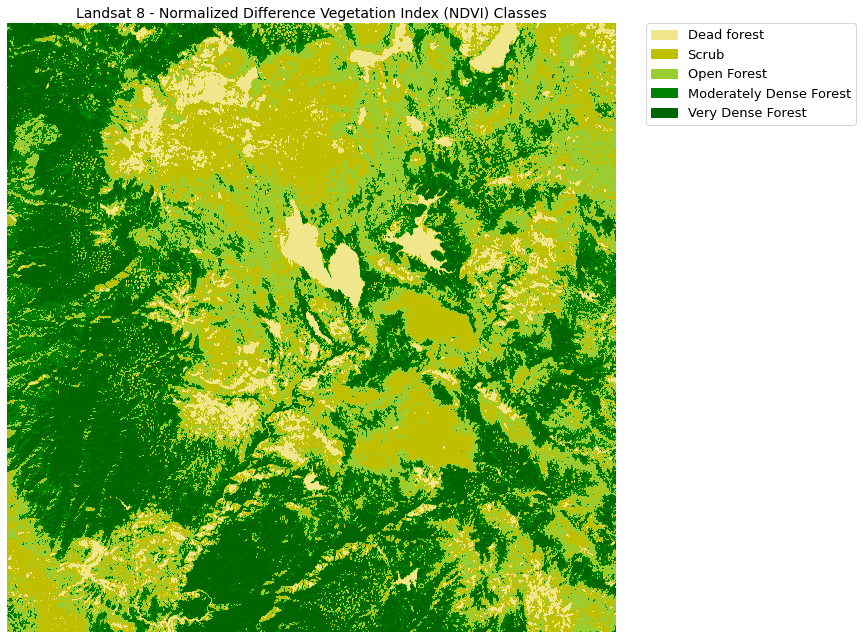

In [35]:
# Define color map
nbr_colors_2 = ["khaki", "y", "yellowgreen", "g", "darkgreen"]
nbr_cmap_2 = ListedColormap(nbr_colors_2)

# Define class names
ndvi_cat_names_2 = [
    "Dead forest",
    "Scrub",
    "Open Forest",
    "Moderately Dense Forest",
    "Very Dense Forest",
]

# Get list of classes
classes_2 = np.unique(ndvi_landsat_class_2)
classes_2 = classes_2.tolist()
# The mask returns a value of none in the classes. remove that
classes_2 = classes_2[0:5]

# Plot your data
fig, ax = plt.subplots(figsize=(12, 12))
im = ax.imshow(np.squeeze(ndvi_landsat_class_2), cmap=nbr_cmap_2)

ep.draw_legend(im_ax=im, classes=classes_2, titles=ndvi_cat_names_2)
ax.set_title(
    "Landsat 8 - Normalized Difference Vegetation Index (NDVI) Classes",
    fontsize=14,
)
ax.set_axis_off()

# Auto adjust subplot to fit figure size
plt.tight_layout()


The above visualization shows us the classification of deforestation  plotted for region. You can see the dense forest area in dark green and dead forest or no forest in contrasting shades.

##Clean Up (Optional)

Though we did not create any AWS billable resources as part of this exercise, the geographic and GIS data that we downloaded and the images generated may take up significant storage. Make sure to check any storage utilization and delete the files as needed.